In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('training.csv')
df = data.iloc[:, 1:10]
df.shape

(72983, 9)

In [3]:
df.head()

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel
0,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I
1,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT
2,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV
3,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN
4,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   IsBadBuy    72983 non-null  int64 
 1   PurchDate   72983 non-null  object
 2   Auction     72983 non-null  object
 3   VehYear     72983 non-null  int64 
 4   VehicleAge  72983 non-null  int64 
 5   Make        72983 non-null  object
 6   Model       72983 non-null  object
 7   Trim        70623 non-null  object
 8   SubModel    72975 non-null  object
dtypes: int64(3), object(6)
memory usage: 5.0+ MB


# Data Exploration

## PurchDate

Data zakupu samochodu na aukcji

In [5]:
df['PurchDate'] = pd.to_datetime(df['PurchDate'])
df['Year'] = df['PurchDate'].dt.year
df['Month'] = df['PurchDate'].dt.month
df['Day'] = df['PurchDate'].dt.day

In [6]:
df.Year.value_counts()

2010    37922
2009    35061
Name: Year, dtype: int64

In [7]:
df.groupby('Year')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Year,,
2010,0.13003,37922
2009,0.11537,35061


Mamy do czynienia z danymi pochodzącymi z dwóch lat, raczej nie będziemy rozpatrywać roku jako istotnej cechy.

<AxesSubplot:>

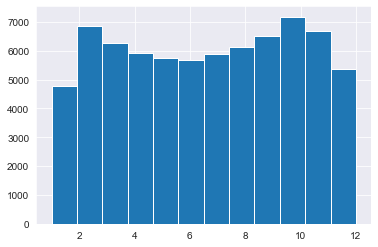

In [8]:
df.Month.hist(bins=12)

Zakupy odbywały się najczęściej w miesiącach jesiennych i wczesnowiosennych, rzadziej latem a najrzadziej na przełomie roku.

In [9]:
df.groupby('Month')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Month,,
3,0.144478,6257
9,0.138842,6511
12,0.133942,5368
1,0.132285,4770
8,0.130477,6139
2,0.130136,6839
4,0.125864,5935
11,0.118652,6675
6,0.111013,5675


Mieszane odczucia - różnica w średnich jest widoczna, szczególnie rzucają się w oczy styczeń i grudzień - jest wtedy również najmniej zakupów, ale mało zakupów jest też latem i średnie są z kolei niskie, kiedy jest najwięcej zakupów - październik, listopad to również mamy niskie średnie. No i wygląda na to że lepiej nie kupować w marcu.

Trzeba będzie pomyśleć czy uwzględniać miesiąc w modelu

<AxesSubplot:>

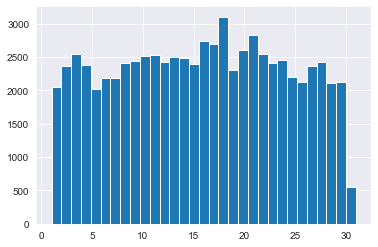

In [10]:
df.Day.hist(bins=31)

In [11]:
df.groupby('Day')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Day,,
31,0.142077,549
3,0.136399,2544
2,0.135249,2366
7,0.133364,2182
1,0.133301,2048
19,0.132812,2304
10,0.132511,2513
30,0.132298,2124
4,0.131127,2387


Z dni nie wynikają żadne interesujące zależności.

**Wnioski: trzeba będzie rozpatrzeć miesiąc jako być może istotną cechę, jeśli tak, wypadałoby zrobić jego preprocessing**

## Auction

Identyfikator dostawcy na aukcji, u którego samochód został kupiony

In [12]:
df.Auction.value_counts()

MANHEIM    41043
OTHER      17501
ADESA      14439
Name: Auction, dtype: int64

In [13]:
df.groupby('Auction')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Auction,,
ADESA,0.151880,14439
OTHER,0.118165,17501
MANHEIM,0.114880,41043


Jest widoczna pewna zależność - uwzględnimy to. Do przeprocesowania jakiś one hot encoder może wleci.

## VehYear

Rok produkcji samochodu

<AxesSubplot:>

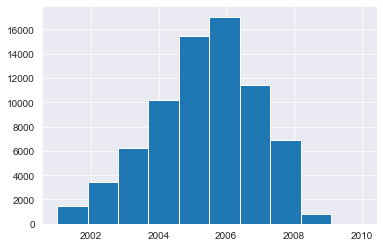

In [14]:
df.VehYear.hist()

In [15]:
df.groupby('VehYear')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
VehYear,,
2001,0.287643,1481
2002,0.240235,3405
2003,0.194315,6227
2004,0.155482,10207
2005,0.131190,15489
2006,0.093880,17043
2007,0.077738,11423
2008,0.055919,6885
2009,0.036496,822


Jest to istotna zmienna z punktu widzenia lemonów.

## VehicleAge

Lata minione od roku produkcji

In [16]:
df.VehYear.corr(df.VehicleAge)

-0.9579570737977844

Bez zaskoczenia, zmienna do usunięcia.

## Make

Producent samochodu

In [17]:
df.Make.value_counts()

CHEVROLET       17248
DODGE           12912
FORD            11305
CHRYSLER         8844
PONTIAC          4258
KIA              2484
SATURN           2163
NISSAN           2085
HYUNDAI          1811
JEEP             1644
SUZUKI           1328
TOYOTA           1144
MITSUBISHI       1030
MAZDA             979
MERCURY           913
BUICK             720
GMC               649
HONDA             497
OLDSMOBILE        243
VOLKSWAGEN        134
ISUZU             134
SCION             129
LINCOLN            97
INFINITI           42
VOLVO              37
CADILLAC           33
ACURA              33
LEXUS              31
SUBARU             28
MINI               24
PLYMOUTH            2
TOYOTA SCION        1
HUMMER              1
Name: Make, dtype: int64

In [18]:
df.groupby('Make')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Make,,
PLYMOUTH,0.500000,2
LEXUS,0.354839,31
INFINITI,0.333333,42
MINI,0.333333,24
LINCOLN,0.298969,97
ACURA,0.272727,33
SUBARU,0.214286,28
OLDSMOBILE,0.201646,243
MERCURY,0.169770,913


Dość istotna kwestia - trzeba będzie się tym zająć.

## Model

Model samochodu

In [19]:
df.Model.value_counts()

PT CRUISER              2329
IMPALA                  1990
TAURUS                  1425
CALIBER                 1375
CARAVAN GRAND FWD V6    1289
                        ... 
ESCAPE                     1
PRIZM 1.8L I-4 SFI D       1
CAMRY V6 3.0L / 3.3L       1
LHS                        1
PATRIOT 2WD 4C 2.0L        1
Name: Model, Length: 1063, dtype: int64

In [20]:
df.groupby('Model')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Model,,
PT CRUISER,0.187205,2329
IMPALA,0.079899,1990
TAURUS,0.147368,1425
CALIBER,0.104000,1375
CARAVAN GRAND FWD V6,0.121800,1289
...,...,...
TRAILBLAZER 4WD V8,0.000000,1
MONTERO 4WD V6 3.8L,0.000000,1
AVALON 3.0L V6 EFI,0.000000,1


No tu będzie trochę zabawy. Widać że dla podobnej liczności średnia może się znacząco różnić.

## Trim

Rodzaj pakietu

In [21]:
df.Trim.info()

<class 'pandas.core.series.Series'>
RangeIndex: 72983 entries, 0 to 72982
Series name: Trim
Non-Null Count  Dtype 
--------------  ----- 
70623 non-null  object
dtypes: object(1)
memory usage: 570.3+ KB


Występuje tu sporo braków danych, ale być może wyciągniemy to ze zmiennej Submodel

In [22]:
df.Trim.value_counts()

Bas    13950
LS     10174
SE      9348
SXT     3825
LT      3540
       ...  
Har        1
LL         1
JLX        1
JLS        1
L 3        1
Name: Trim, Length: 134, dtype: int64

In [23]:
df.groupby('Trim')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Trim,,
Bas,0.123799,13950
LS,0.087871,10174
SE,0.122914,9348
SXT,0.098824,3825
LT,0.074859,3540
...,...,...
Har,0.000000,1
LL,0.000000,1
Maz,1.000000,1


## SubModel

Zmienna opisuje liczbę drzwi samochodu, typ (można powiedzieć że prawie jak rozmiar Size), pakiet (Trim) oraz pojemność silnika

In [24]:
df.SubModel.info()

<class 'pandas.core.series.Series'>
RangeIndex: 72983 entries, 0 to 72982
Series name: SubModel
Non-Null Count  Dtype 
--------------  ----- 
72975 non-null  object
dtypes: object(1)
memory usage: 570.3+ KB


Występuje tu całe 8 braków danych. Jakoś sobie chyba z tym poradzimy.

In [25]:
df.SubModel.value_counts()

4D SEDAN                  15236
4D SEDAN LS                4718
4D SEDAN SE                3859
4D WAGON                   2230
MINIVAN 3.3L               1258
                          ...  
EXT CAB 5.4L FX2 SPORT        1
2D COUPE ZX5 S                1
4D WAGON OUTBACK              1
EXT CAB 6.0L SLE              1
MINIVAN 3.3L FFV EL           1
Name: SubModel, Length: 863, dtype: int64

In [26]:
df.groupby('SubModel')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
SubModel,,
4D SEDAN,0.122276,15236
4D SEDAN LS,0.077363,4718
4D SEDAN SE,0.133454,3859
4D WAGON,0.100448,2230
MINIVAN 3.3L,0.099364,1258
...,...,...
4D SUV 4.7L SLT PLUS,0.000000,1
MINIVAN LX,0.000000,1
4D SUV 4.7L FFV LIMITED,0.000000,1


Ze tej zmiennej będzie mozna wyciągnąć liczbę drzwi w samochodzie oraz pojemność silnika. Rozmiar samochodu jest już uwzględniony w zmiennej Size, zaś pakiet w zmiennej Trim.